## For better visualization, need new packages

ipympl, mplcursors
```
conda install -c conda-forge ipympl mplcursors
```

In [1]:
# Comment out the following if you don't have ipympl
%matplotlib widget
from copy import copy

import matplotlib.pyplot as plt
import numpy as np
from config import CONFIG, DistributionConfig
from config.grid import GRID_CONFIG, ResetConfig, SwingConfig, MonitorConfig
from config.rl import RL_CONFIG
from matplotlib.backend_bases import MouseEvent
from matplotlib.colors import to_hex
from matplotlib.widgets import Button, Slider
from smu_grid import (Grid, NodeType, create_couplings, create_graph,
                      create_node_types, create_nodes, reset)

from config.grid import PerturbationConfig, RebalanceConfig

rng = np.random.default_rng(42)

# Configuration

## Rule of thumb
- If you want to change configuration for entire program, change CONFIG, GRID_CONFIG, RL_CONFIG
- Other custom configurations is only applied single time

In [2]:
"""Default values are from python code at `config` directory"""
print(CONFIG.grid.generator_spare, GRID_CONFIG.generator_spare)

1.1 1.1


In [3]:
""" Read and write configuration. Only CONFIG is writable, readable"""

# CONFIG.to_yaml("config.yaml") # write
CONFIG.from_yaml("config.yaml")  # read
print(CONFIG.grid.generator_spare, GRID_CONFIG.generator_spare)

1.0 1.0


In [4]:
""" Any manual assignment is synchronized between configurations """
CONFIG.grid.generator_spare = 1.3
print(CONFIG.grid.generator_spare, GRID_CONFIG.generator_spare)

GRID_CONFIG.generator_spare = 1.1
print(CONFIG.grid.generator_spare, GRID_CONFIG.generator_spare)

1.3 1.3
1.1 1.1


In [5]:
""" When invalid manual assignment, raise user warning and ignore the assignment"""
CONFIG.grid.generator_spare = 0.9
print(CONFIG.grid.generator_spare, GRID_CONFIG.generator_spare)


1.1 1.1


/tmp/ipykernel_1153721/1380419242.py:2: UserWarning: Generator spare should be large or equal to 1. Ignore
  CONFIG.grid.generator_spare = 0.9


# Create grid

In [2]:
""" Manually create grid components with manual setting. Default: GRID_CONFIG """

# Use custom distribution
my_mean_degree_distribution = DistributionConfig(name="uniform", low=5, high=5)
graph = create_graph(
    rng=rng,
    # num_nodes_distribution = GRID_CONFIG.graph.num_nodes_distribution,    # default
    mean_degree_distribution=my_mean_degree_distribution,  # custom distribution
    # topology = GRID_CONFIG.graph.topology,    # default
    # shk = GRID_CONFIG.graph.shk,  # default
)

# You don't even need to use create function. Just manually assign proper values
couplings = rng.uniform(10.0, 50.0, size=graph.number_of_edges())
# couplings = create_couplings(  # Default way to create couplings
#     graph.number_of_edges(),
#     rng,
#     coupling_distribution=GRID_CONFIG.coupling_distribution,
# )

# Use custom number of ratio in dictionary format
my_num_ratio = {"generator": 0.25, "renewable": 0.25, "consumer": 0.25, "sink": 0.25}
node_types = create_node_types(
    graph.number_of_nodes(),
    rng,
    # num_ratio=my_num_ratio,  # Can be both dictionary or NumRatioConfig instance
)

# Change the default config
GRID_CONFIG.sink_spare = 1.1
nodes = create_nodes(
    node_types,
    rng,
    # consumer_capacity_distribution = GRID_CONFIG.consumer_capacity_distribution,
    # generator_spare = GRID_CONFIG.generator_spare,
    # generator_capacity_distribution = GRID_CONFIG.generator_capacity_distribution,
    # renewable_capacity_distribution = GRID_CONFIG.renewable_capacity_distribution,
    # renewable_mass_distribution = GRID_CONFIG.renewable_mass_distribution,
    # sink_capacity_distribution = GRID_CONFIG.sink_capacity_distribution,
    # source_ratio = GRID_CONFIG.source_ratio,
    # sink_spare = GRID_CONFIG.sink_spare,
)

<class 'NoneType'>
NumRatioConfig(consumer=0.3, generator=0.4, renewable=0.2, sink=0.1)


In [3]:
""" Grid can be both created from components
which are manually created or automatically created based on GRID_CONFIG

If given arguments are not compatible, raise AssertionError
"""
grid = Grid(
    rng,
    graph=graph,    # Assign manually created graph
    couplings=couplings,    # Assign manually created couplings
    node_types=node_types,    # Assign manually created node_types
    nodes=None,  # Default, Automatically create random compatible nodes
    # nodes=nodes[:-1],  # incompatible with graph & node_types -> raise AssertionError
)
print(grid)
print()

"""
After initialization of grid, the grid is currently offline, meaning there is no active units
Therefore, if you want to run any dynamics on the grid, you should turn it on first

Turn on can be done in various ways.
For detailed documentation, see config/turn_on.py
"""
# Create my custom turn_on configuration from default config
my_turn_on = copy(GRID_CONFIG.turn_on)

# Manual assignment of active units
my_turn_on.strategy = "manual"
my_num_active_units = rng.integers(
    np.ones(grid.num_nodes, dtype=np.int64), [node.max_units for node in grid.nodes]
)

# Turn on the grid
grid.turn_on(
    config=my_turn_on,
    num_active_units=my_num_active_units
)
print(grid)

# Surely, you can also make the grid offline
# grid.turn_off()

Node 0 - generator, max: 12, active: 0
Node 1 - generator, max: 5, active: 0
Node 2 - consumer, max: 10, active: 0
Node 3 - sink, max: 10, active: 0
Node 4 - generator, max: 7, active: 0
Node 5 - renewable, max: 7, active: 0
Node 6 - renewable, max: 2, active: 0
Node 7 - consumer, max: 10, active: 0
Node 8 - consumer, max: 10, active: 0
Node 9 - generator, max: 9, active: 0

Node 0 - generator, max: 12, active: 2
Node 1 - generator, max: 5, active: 1
Node 2 - consumer, max: 10, active: 8
Node 3 - sink, max: 10, active: 8
Node 4 - generator, max: 7, active: 2
Node 5 - renewable, max: 7, active: 5
Node 6 - renewable, max: 2, active: 1
Node 7 - consumer, max: 10, active: 8
Node 8 - consumer, max: 10, active: 4
Node 9 - generator, max: 9, active: 1


# Plot grid

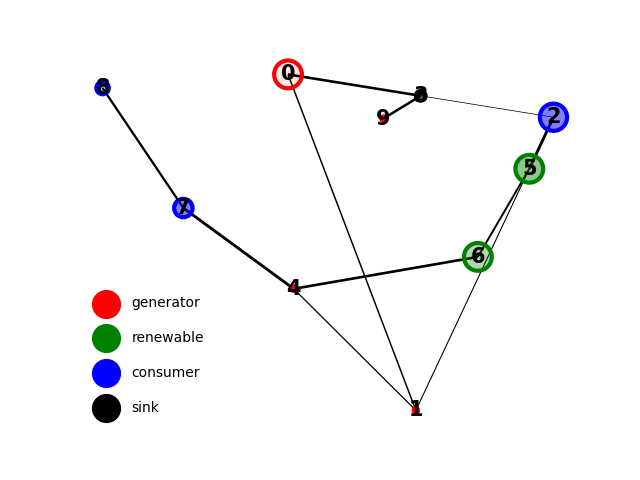

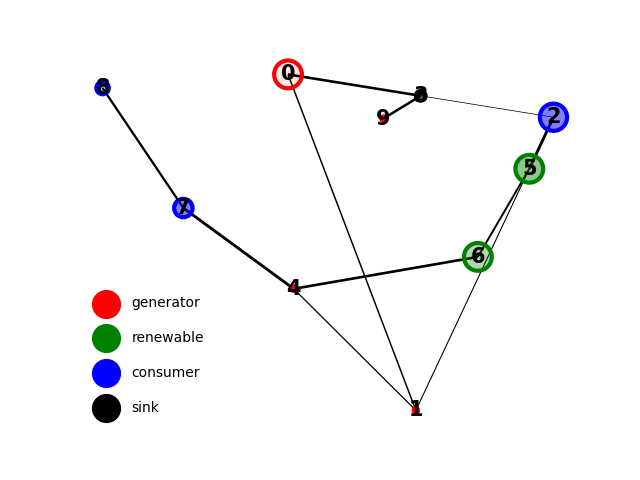

In [ ]:
def get_node_sizes(dphase: np.ndarray, max_size: float) -> np.ndarray:
    node_sizes = np.exp(np.abs(dphase))
    return np.clip(node_sizes, 10, max_size)


plt.close("all")
fig, ax = plt.subplots()

# Node color-code by it's type
color = {
    NodeType.GENERATOR: "r",
    NodeType.RENEWABLE: "g",
    NodeType.CONSUMER: "b",
    NodeType.SINK: "k",
}
node_colors = [to_hex(color[node.type]) for node in grid.nodes]

# Node size by it's size of dphase
max_size = 400  # Maximum node size
dummy_dphase = rng.uniform(-10.0, 10.0, grid.num_nodes)

# Default drawing of grid
grid.draw(
    ax,
    margins=0.0,  # As little whitespace as possible
    node_color=[  # trasparency depending on it's activeness
        f"{color}{node.ratio * 100:02.0f}"
        for color, node in zip(node_colors, grid.nodes)
    ],
    edgecolors=node_colors,  # Node boarder color
    linewidths=3,  # Node boarder width
    node_size=get_node_sizes(dummy_dphase, max_size),
    width=grid.couplings / 20,  # Edge width
    with_labels=True,  # Include node index
    font_color="k",  # Node index color
    font_weight="heavy",  # Node index weight
    font_size=15,  # Node index size
)

# Legend
ax.scatter([], [], color=color[NodeType.GENERATOR], s=max_size, label="generator")
ax.scatter([], [], color=color[NodeType.RENEWABLE], s=max_size, label="renewable")
ax.scatter([], [], color=color[NodeType.CONSUMER], s=max_size, label="consumer")
ax.scatter([], [], color=color[NodeType.SINK], s=max_size, label="sink")
ax.legend(labelspacing=1.5, frameon=False)


fig.show()

# Reset grid

In [5]:
"""
You can set reset range with both dictionary and ResetConfig

Note that the new grid from reset is different object
NOTE: You should turn on the grid once again
"""
my_reset_config = {"graph": False, "coupling": False, "node_type": True, "node": True}
# my_reset_config = ResetConfig(graph=False, coupling=False, node_type=False, node=False)

# Custom configuration used for reset: Anything related to create functions
my_coupling_distribution = DistributionConfig(name="uniform", low=20.0, high=20.0)

print(id(grid))

grid = reset(
    grid,
    # config=RL_CONFIG.reset,
    config = my_reset_config,
    # coupling_distribution=my_coupling_distribution  # custom config
    num_ratio=my_num_ratio
)
grid.turn_on()

print(id(grid))


140540147081168
140540147081168


# Find steady state

In [4]:
"""
Use solve function to solve swing equation on grid
If the grid is offline, it will raise UserWarning and return empty array

The swing equation solving requires a SwingConfig as input argument
For detailed documentation, see 'config/swing.py'

For initial condition, you can manually assign them or use default zero-array
Return the full trajectory of the dynamics
"""

# Create my custom steady state configuration
my_steady_config = SwingConfig(
    _name="rk4",
    dt=1e-2,
    max_time=40.0,
    monitor=MonitorConfig("inside", 1e-3)
)

# Manually assign initial condition
my_initial_phase = rng.uniform(-np.pi, np.pi, size=grid.num_nodes)

# Solve swing equation and return trajectory of phase/dphase
phases, dphases = grid.run(
    config=my_steady_config,  # Use custom configuration, Default: GRID_CONFIG.steady
    phase=my_initial_phase, # Custom initial phase
    # dphase=None,  # Default: zero-array
)


"""
The resulting trajectory may be shorter than expected.
This is due to the 'Monitor' behavior, which monitors the trajectory and early stop iteration if it meets certain condition.

For example, in case of 'InsideMonitor' used in GRID_CONFIG.steady, it checks if all velocity is inside the given threshold range.
For more information, see 'environment/smu_grid/monitor.py'
"""
time = np.arange(len(phases)) * my_steady_config.dt
final_time = time[-1]

if final_time < my_steady_config.max_time:
    print(f"Found steady state at t={final_time}")
    print(f"phase ={np.round(phases[-1], 2)}")
    print(f"dphase={np.round(dphases[-1], 2)}")
else:
    print("Failed to find steady state")
    print(f"Maximum velocity = {np.abs(dphases[-1]).max():.2e}")

Found steady state at t=32.61
phase =[ 0.04 -0.24 -0.35  0.15 -0.55 -0.31 -0.44 -0.85 -0.97  0.18]
dphase=[-0.  0.  0. -0.  0.  0.  0.  0.  0. -0.]


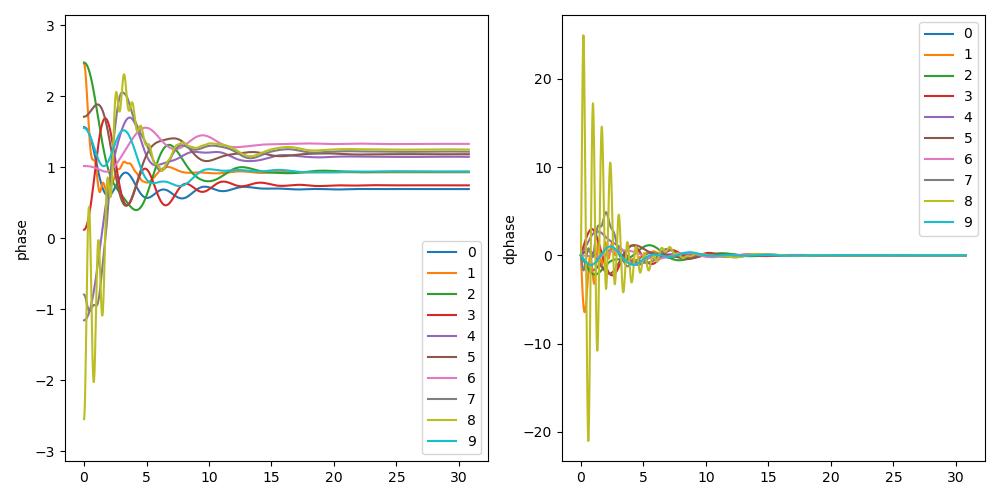

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

for i, (phase, dphase) in enumerate(zip(phases.T, dphases.T)):
    ax1.plot(time, phase, label=i)
    ax2.plot(time, dphase, label=i)

ax1.legend()
ax1.set_ylabel("phase")
ax1.set_ylim(-np.pi, np.pi)
ax2.legend()
ax2.set_ylabel("dphase")

fig.tight_layout()

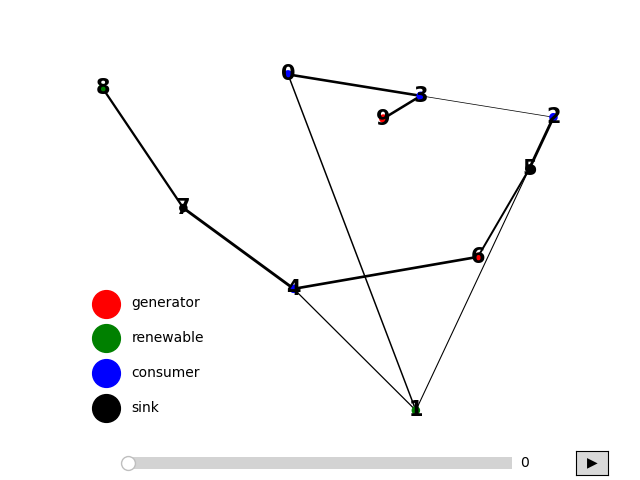

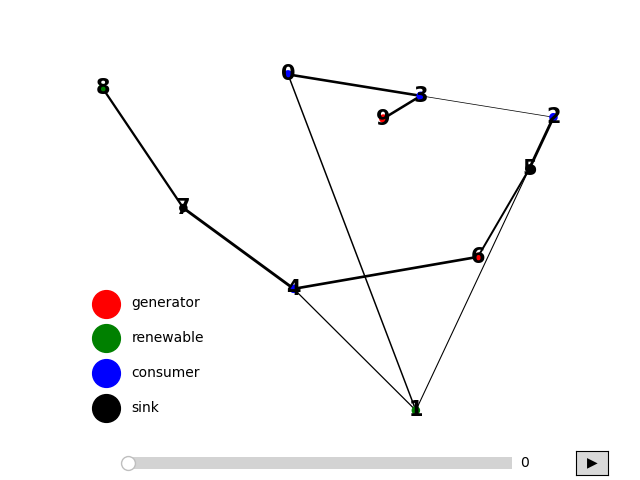

In [ ]:
max_size, dt_plot = 400.0, 0.05


def get_node_sizes(dphase: np.ndarray, max_size: float = max_size) -> np.ndarray:
    node_sizes = np.exp(np.abs(dphase))
    return np.clip(node_sizes, 10, max_size)

def time_to_frame(time: float) -> int:
    return round(time / dt_plot)

def frame_to_idx(frame) -> int:
    return round(frame * dt_plot / my_steady_config.dt)


fig, ax = plt.subplots()
color = {
    NodeType.GENERATOR: "r",
    NodeType.RENEWABLE: "g",
    NodeType.CONSUMER: "b",
    NodeType.SINK: "k",
}
node_colors = [to_hex(color[node.type]) for node in grid.nodes]

# Create the slider & play/pause button & timer
slider_ax = plt.axes((0.2, 0.01, 0.6, 0.05))  # [left, bottom, width, height]
slider = Slider(slider_ax, "", 0, time_to_frame(final_time), valinit=0, valstep=10)
button_ax = plt.axes((0.9, 0.01, 0.05, 0.05))  # [left, bottom, width, height]
button = Button(button_ax, "▶")
timer = fig.canvas.new_timer(interval=200)

node_objects = grid.draw(
    ax,
    cursors=False,
    margins=0.0,  # As little whitespace as possible
    node_color=[  # trasparency depending on it's activeness
        f"{color}{node.ratio * 100:02.0f}"
        for color, node in zip(node_colors, grid.nodes)
    ],
    edgecolors=node_colors,  # Node boarder color
    linewidths=3,  # Node boarder width
    node_size=get_node_sizes(dphases[0]),
    width=grid.couplings / 20,  # Edge width
    with_labels=True,  # Include node index
    font_color="k",  # Node index color
    font_weight="heavy",  # Node index weight
    font_size=15,  # Node index size
)
ax.scatter([], [], color=color[NodeType.GENERATOR], s=max_size, label="generator")
ax.scatter([], [], color=color[NodeType.RENEWABLE], s=max_size, label="renewable")
ax.scatter([], [], color=color[NodeType.CONSUMER], s=max_size, label="consumer")
ax.scatter([], [], color=color[NodeType.SINK], s=max_size, label="sink")
ax.legend(labelspacing=1.5, frameon=False)


def slider_callback(frame: int) -> None:
    time_idx = frame_to_idx(frame)
    node_objects.set_sizes(get_node_sizes(dphases[time_idx]))
    slider.valtext.set_text(f"t={time[time_idx]:.2f}")
    fig.canvas.draw_idle()
    fig.canvas.flush_events()


def button_callback(event: MouseEvent) -> None:
    if button.label.get_text() == "▶":
        button.label.set_text("||")
        timer.start()
    else:
        button.label.set_text("▶")
        timer.stop()


def timer_callback() -> None:
    if slider.val >= slider.valmax:
        button.label.set_text("▶")
        timer.stop()
    else:
        slider.set_val(slider.val + 1)


# Connect the slider, button, timer
slider.on_changed(slider_callback)
button.on_clicked(button_callback)
timer.add_callback(timer_callback)

fig.show()

# (Power) Perturbation and Rebalance

In [8]:
"""
To invoke perturbation on grid, you need to mark the perturabation first using 'grid.mark_perturbations'.
If grid is already in power imbalance state, it will raise UserWarning and do nothing.

The configuration of perturbation is needed for 'mark_perturbations'
NOTE: this may change as we consider various type of perturbations

The return of mark_perturbations will indicate the size and direction of the perturbation for each nodes.
Next, you can apply the perturbation to the grid using 'grid.perturbate'.
This will indeed change the state of grid
"""

# Create an perturbation configuration object and use it
my_perturbation = PerturbationConfig(size=3)
perturbations = grid.mark_perturbations(my_perturbation)    # Default: GRID_CONFIG.perturbation
# perturbations = grid.mark_perturbations(3)  # Or, directly give size

print("Perturbation will occur as follows")
for i, (node, perturbation) in enumerate(zip(grid.nodes, perturbations)):
    if perturbation == 0:
        continue
    print(f"node {i}: {node} will perturabate {perturbation}")

grid.perturbate(perturbations)
print("\nAfter perturbation")
print(f"{grid.power_imbalance=}")
print(grid)

Perturbation will occur as follows
node 2: consumer, max: 10, active: 9 will perturabate 1
node 7: consumer, max: 10, active: 9 will perturabate -2

After perturbation
grid.power_imbalance=1
Node 0 - generator, max: 12, active: 2
Node 1 - generator, max: 5, active: 1
Node 2 - consumer, max: 10, active: 10
Node 3 - sink, max: 10, active: 1
Node 4 - generator, max: 7, active: 7
Node 5 - renewable, max: 7, active: 5
Node 6 - renewable, max: 2, active: 1
Node 7 - consumer, max: 10, active: 7
Node 8 - consumer, max: 10, active: 5
Node 9 - generator, max: 9, active: 6


In [9]:
"""
If you want to rebalance the perturbation, you can either use 'grid.rebalnce' or manually increase/decrease nodes

rebalance function requires rebalance configuration, which contains detailed information of re-balancing.
Read config/grid/rebalance.py for detailed documentation

NOTE: grid.rebalance can be fail if given weight is not good enough.
"""

# Use rebalance method
rebalance_config = RebalanceConfig(_strategy="undirected", max_trials=1000)

balanced = False
while not balanced:
    # Create any weights that is compatible with rebalance config
    weights = rng.uniform(-1.0, 1.0, size=grid.num_nodes).astype(np.float32)
    weights *= (grid.is_generator + grid.is_sink)
    balanced = grid.rebalance(rebalance_config, weights)

# Manually do rebalance
# grid.nodes[4].increase()

print("After rebalancing")
print(f"{grid.power_imbalance=}")
print(grid)


After rebalancing
grid.power_imbalance=0
Node 0 - generator, max: 12, active: 4
Node 1 - generator, max: 5, active: 1
Node 2 - consumer, max: 10, active: 10
Node 3 - sink, max: 10, active: 1
Node 4 - generator, max: 7, active: 7
Node 5 - renewable, max: 7, active: 5
Node 6 - renewable, max: 2, active: 1
Node 7 - consumer, max: 10, active: 7
Node 8 - consumer, max: 10, active: 5
Node 9 - generator, max: 9, active: 3
